# Algoritmo de relacionamiento de elementos comunes de testimonios escritos de víctimas del conflicto armado en Colombia

## Instala dependencias

In [ ]:
pip install -U spacy

In [ ]:
!python -m spacy download es_core_news_sm

## Importa dependencias

In [1]:
import spacy
# Modelo entrenado para idioma español
spc = spacy.load('es_core_news_sm')
# Importa Stop Words
from spacy.lang.es.stop_words import STOP_WORDS
import pandas as pd
pd.options.display.max_colwidth = 1000
%matplotlib inline
import matplotlib.pyplot as plt
import os
from os import listdir
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from io import open

## Carga de documentos para establecer el corpus

In [2]:
# Ubicación de carpeta con testimonios
path = os.getcwd()+"/testimonios/"
# Crear lista vacía para los testimonios
lista_archivos=[]
# Ciclo for para identificar los archivos que tengan punto en su nombre
# el path es la carpeta testimonios
for archivos in listdir(path):
    # Si se encuentran archivos con extensión .txt
    if (".txt" in archivos):
        # Cárguelos a la lista que inició vacía
        lista_archivos.append(archivos)

In [3]:
# Lista de nombres archivos con extensión txt en la carpeta
pd.DataFrame({"Archivo":lista_archivos})

,Archivo
0,Bojaya.txt
1,Montes_de_maria.txt
2,Segovia.txt
3,Trujillo.txt
4,Cauca.txt
5,Sintetico.txt
6,Bahia_portete.txt


In [4]:
# Carga corpus a variable
# Crear lista vacía
corpus=[]
# Ciclo for para identificar cada archivo que está en la variable (de tipo lista) lista_testimonios
for testimonio in lista_archivos:
    # Abra cada testimonio en formato lectura
    testim = open(path+testimonio,"r")
    # Cargue el texto completo
    lee_texto = testim.read()
    # Cierre el archivo que se abrió
    testim.close()
    # Lleve el texto completo (testimonio a la lista de corpus)
    corpus.append(lee_texto)

In [5]:
# Dataframe del corpus
# Tamaño del corpus en palabras por cada testimonio y suma total
tamanocorpus = [len(amp) for amp in corpus]
tottamanocorpus = sum(tamanocorpus)
palabra_documento = [len(elemento.split()) for elemento in corpus]
tottamanocorpuspalabra = sum(palabra_documento)
dftamanocorpus = pd.DataFrame({"Archivo":lista_archivos,"Palabras":palabra_documento,"Caracteres":tamanocorpus,"Testimonio":corpus})
dftamanocorpus

,Archivo,Palabras,Caracteres,Testimonio
0,Bojaya.txt,1659,8822,"Mi nombre es Rosa de la Nieve Mosquera Cuello, lo que soy se lo debo a Bojayá y me desvivo por Bojayá \nRosa nació en Necoclí en la región de Urabá, a los 7 años se mudó con su familia a Bojayá un municipio en el departamento del Chocó, al noroeste de Colombia, en la región del Pacífico. Rosa es sobreviviente de lo que se conoce como la masacre de Bojayá, ocurrida el 2 de mayo del 2002, ese día murieron 79 civiles de los cuales 48 eran menores de edad. En un combate con los paramilitares, el bloque 58 de las FARC lanzó un cilindro bomba al interior de la iglesia, ese día Rosa estaba con más de 300 personas y sus seis hijos, refugiados en la iglesia. Rosa tienen hoy 48 años, y es la mayor de 6 hermanos, todos fueron criados en Bojayá por su abuela paterna, la relación de Rosa con ella no fue fácil, pues su abuela la maltrataba\nEntonces son, unos de los maltratos que uno aprende a perdonar pero que siempre quedan secuelas, cuando uno se viste y se mira uno dice: esto me lo hizo mi ..."
1,Montes_de_maria.txt,1605,9059,"Nací en El Carmen de Bolívar, en el barrio El Porvenir ahí vivo aún…\n\nEsta es Soraya Bayuelo, hoy tiene 55 años, y en 1994 junto con comunicadores, maestros y líderes comunitarios del Carmen de Bolívar creó lo que se conoce como el colectivo de comunicaciones “Montes de María”, Soraya nos resume qué es…\n\nNace de las entrañas de la casa de la cultura, es un proyecto con una claridad desde los principios de defensa de los derechos humanos, especialmente el derecho a la comunicación es un proyecto de transformación social, que creíamos que hubiese podido seguir normal, ¿verdad? Si no irrumpe el conflicto armado…\n\nEl conflicto al que se refiere Soraya es a la lucha entre guerrilleros y paramilitares, que empezó con la llegada de la guerrilla a la zona a mediados de los 80’s y la zona es: Montes de María, una región del Caribe interno colombiano ubicado entre los departamentos de Sucre y Bolívar, donde entre 1999 y el 2001 hubo 42 masacres que dejaron 354 civiles asesinados… Tal v..."
2,Segovia.txt,1387,7932,"Porque con la masacre las víctimas fuimos todos, todo el pueblo de Segovia quedó victimizado con esa masacre, pero ya nosotros quedamos con todas esas secuelas. Era el miedo a la noche, miedo a lo extraño.\nEste es Fernando, mejor conocido como “el profe”, nació en 1962 en Segovia, un municipio del nordeste de Antioquia, un departamento de Colombia. Desde 1982 hasta 1997 Segovia, como la población cercana de Remedios, experimentó una violencia política recurrente contra la población civil, iba dirigida sobre todo hacia los partidos políticos de izquierda: el partido comunista, MOIR, A luchar, Unión patriótica; pero también iba dirigida a los miembros de sindicatos, de comités de Derechos Humanos, juntas cívicas y asociaciones comunitarias. Esta la historia de una de las cuatro masacres más significativas ocurridas en la región y la oiremos a través del testimonio de Fernando. Se trata de la masacre del 11 de noviembre de 1988 donde en una alianza conformada por miembros del ejércit..."
3,Trujillo.txt,1471,8211,"Siempre he sufrido la violencia, ¿por qué? Porque a mi papá lo asesinaron siendo yo muy niña\n\nElla es Ludivia y su vida ha estado marcada por muchos tipos de violencias, nació 1952, en el Valle del Cauca, un departamento al sur occidente de Colombia, toda la vida ha sido partera y hoy se define como evangelizadora y líder comunitaria. Ludivia es vicepresidente de la asociación de víctimas de Trujillo, que se creó en 1995, después de lo que se conoce como la masacre de Trujillo, que no fue de un día sino de siete años de violencia casi continua en los municipios de Trujillo Bolívar y Río Frío al noroccidente del Valle, desde 1988 hasta 1994 se registraron 342 víctimas de homicidio tortura y desaparición forzada esta masacre fue cometida por una alianza entre narcotraficantes, paramilitares y miembros de la policía y el ejército colombian

## Define funciones de preprocesamiento

In [6]:
# Corrector ortográfico
# Inicialmente debe importar el módulo corrector desde el archivo
from ortografia.corrector_ortografico import correction
def corrct(texto):
    cp_funct_cror = []
    for k in texto:
        # Tokeniza palabras
        tk = spc(str(k))
        # realiza la correción ortográfica
        tkn = [correction(str(o)) for o in tk]
        # Crea nuevamente la oración
        tkn = ' '.join(list(tkn))
        cp_funct_cror.append(tkn)
    return cp_funct_cror

In [7]:
# Lematizar
def lmt(texto):
    cp_funct_lmt = []
    for k in texto:
        # Tokeniza palabras
        tk = spc(str(k))
        # Agrega elemento a lista si no es caracter especial
        tkn = [o.lemma_ for o in tk]
        # Crea nuevamente la oración
        tkn = ' '.join(list(tkn))
        cp_funct_lmt.append(tkn)
    return cp_funct_lmt

In [8]:
# Elimina espacios en blanco
# Esta función tiene una alternativa en la función que engloba el preprocesamiento
# No es necesario cargar en funcion global
def whitespaces(texto):
    cp = [e.strip() for e in texto]
    return cp

In [9]:
# ELiminar caracteres especiales y pasar a minúsculas
def crhsp_and_case(texto):
    cp_funct_sp_crh_case = []
    for k in texto:
        # Tokeniza palabras
        tk = spc(str(k))
        # Agrega elemento a lista si no es caracter especial
        tkn = [o.orth_.lower() for o in tk if not o.is_punct]
        # Crea nuevamente la oración
        tkn = ' '.join(list(tkn))
        cp_funct_sp_crh_case.append(tkn)
    return cp_funct_sp_crh_case

In [10]:
# ELiminar Stopwords
def stp(texto):
    cp_funct_stp = []
    for k in texto:
        # Tokeniza oraciones
        k = spc(str(k))
        tkn =[]
        # Tokeniza palabras
        for tkw in k:
            tkw = str(tkw)
        # Agrega elemento a lista si no es caracter especial
            if tkw not in STOP_WORDS:
                tkw = str(tkw)
                tkn.append(tkw)
        # Crea nuevamente la oración
        tkn = ' '.join(list(tkn))
        cp_funct_stp.append(tkn)
    return cp_funct_stp

In [11]:
### Función que se encarga de realizar todo el prepocesamiento
def total (texty):
    ## Normalización
    # Ortografía
    #texty = corrct(texty)
    # Lemmas
    #texty = lmt(texty)
    ## Limpieza
    # Eliminar espacios en blanco 1
    #texty = [e.strip() for e in texty]
    # Caracteres especiales y conversión a minúsculas
    texty = crhsp_and_case(texty)
    # Eliminar Stopwords
    texty = stp(texty)
    # Eliminar espacios en blanco 2
    texty = [e.strip() for e in texty]
    return texty

## Información parcial del proceso (Stop Words)

In [12]:
# Presentación parcial de funciones de preprocesamiento y normalización

print ("""
Se han cargado las funciones de procesamiento
    + El corrector ortográfico en la función 'corrct(texto)'
    + La función lematizadora en 'lmt(texto)'
    + La supresión de caracteres especiales y el cambio a minpusculas con la función 'crhsp_and_case(texto)'
    + La eliminación depalabras vacías o StopWords con la función 'stp(texto)'
La función que compila todas las anteriores funciones es 'total (texty)'
""")


Se han cargado las funciones de procesamiento
    + El corrector ortográfico en la función 'corrct(texto)'
    + La función lematizadora en 'lmt(texto)'
    + La supresión de caracteres especiales y el cambio a minpusculas con la función 'crhsp_and_case(texto)'
    + La eliminación depalabras vacías o StopWords con la función 'stp(texto)'
La función que compila todas las anteriores funciones es 'total (texty)'



In [13]:
# Ciclo para presentar datos

print("""
>>> Se han cargado """ + str(len(STOP_WORDS)) + """ Palabras vacías o StopWords <<<

    * Sí desea concocer las palabras vacías, presione 1
    * Sí desea consultar si el sistema considera una palabras vacía, presione 2
    * Para contnuar, ingrese cualquier otro número
""")
op = int(input("Su opción: "))
if op == 1:
    print(STOP_WORDS)
if op == 2:
    preg = input("Qué palabra desea consultar? ")
    if preg in STOP_WORDS:
        print(">> " + preg + " << Sí se encuentra!")
    else:
        print(">> " + preg + " << No está en el diccionario!")
        print("Desea agrgarla?")
        nostpw = input("Escriba >S< para Sí; cualquier otra opción para No: ")
        if nostpw.upper() == "S":
            STOP_WORDS.add(preg.lower())
            print("La palabra " + preg + " fue agregada")


>>> Se han cargado 521 Palabras vacías o StopWords <<<

    * Sí desea concocer las palabras vacías, presione 1
    * Sí desea consultar si el sistema considera una palabras vacía, presione 2
    * Para contnuar, ingrese cualquier otro número

Su opción: 2
Qué palabra desea consultar? Avión
>> Avión << No está en el diccionario!
Desea agrgarla?
Escriba >S< para Sí; cualquier otra opción para No: S
La palabra Avión fue agregada


## Carga diccionario con dimensiones

In [14]:
# Carga archivo de diccionarios

filename = 'diccionarios/diccionarios.csv'
diccionarios = pd.read_csv(filename, header=0)
nombre_columnas = list(diccionarios.columns.values)

In [15]:
# Asignar los valores de las dimensiones a variables de tipo lista, 
# eliminado los elementos duplicados
# También se aplica preprocesador

lista_ubicaciones = list(set(total(diccionarios["Ubicaciones"])))
###lista_ubicaciones = list(set(diccionarios["Ubicaciones"]))
lista_hecho_victimizante = list(set(total(diccionarios["Hecho Victimizante"])))
lista_afectacion = list(set(total(diccionarios["Afectación"])))
lista_temporalidad = list(set(total(diccionarios["Temporalidad"])))
lista_entidades = list(set(total(diccionarios["Entidades"])))

In [ ]:
# Celda de test
#print(diccionarios.shape)
#print (diccionarios.head(10))
#print (diccionarios[["Ubicaciones","Afectación"]].head(10))
#diccionarios.info()
#print (diccionarios.iloc[6:14,2:4])
#print (diccionarios[["Ubicaciones"]].head(10))

## Información parcial del proceso (Dimensiones)

In [16]:
# Crea DataFrame de cantidad de elementos por dimensión
infodimensiones = [len(lista_ubicaciones),len(lista_hecho_victimizante),len(lista_afectacion),
                   len(lista_temporalidad),len(lista_entidades)]
dimensiones = ["Ubicaciones","Hecho Victimizante","Afectación","Temporalidad","Entidades"]
dfdimensiones = pd.DataFrame({"Dimensión":dimensiones,"Cantidad":infodimensiones})

print("Resumen")
print("Se cargaron", len(dimensiones), "dimensiones con la siguiente distribución")

dfdimensiones

Resumen
Se cargaron 5 dimensiones con la siguiente distribución


,Dimensión,Cantidad
0,Ubicaciones,1113
1,Hecho Victimizante,103
2,Afectación,76
3,Temporalidad,52
4,Entidades,132


[Text(0, 0, '1,113'),
 Text(0, 0, '103'),
 Text(0, 0, '76'),
 Text(0, 0, '52'),
 Text(0, 0, '132')]

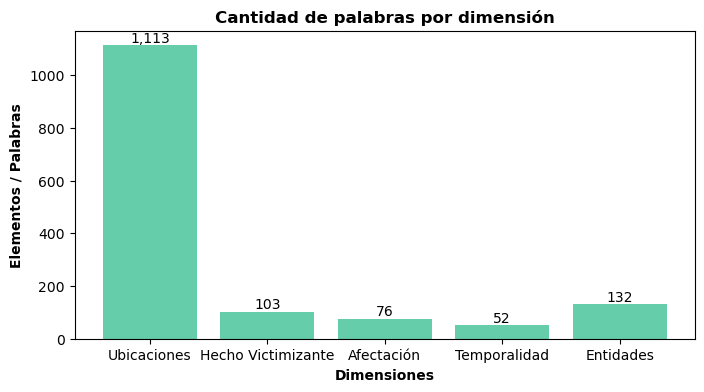

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
bar_container = ax.bar(dimensiones, infodimensiones, color = "mediumaquamarine")
plt.ylabel('Elementos / Palabras', weight='bold')
plt.title("Cantidad de palabras por dimensión", weight='bold')
plt.xlabel("Dimensiones", weight='bold')
ax.bar_label(bar_container, fmt='{:,.0f}')

In [18]:
## Función para búsqueda de palabra en dimensiones

def busca_palabra_en_dimension():
    global busq2
    busq2 =[]
    for i in nombre_columnas:
        ww=[w for w in diccionarios[i] if w == preg2.lower()]
        if len(ww)>0:
            busq2.append(i)
    return busq2

In [19]:
# Ciclo de presentación y búsqueda de dimensiones

print("""
    * Sí desea ver las palabras de una dimensión, presione el número correspondiente a su índice
    * Sí desea consultar si se ha considerado una palabra en cualquier dimensión, presione 9
    * Para contnuar, introduzca un número que no esté en el listado
""")

op2 = int(input("Su opción: "))
if op2 == 0:
    print(pd.DataFrame(lista_ubicaciones).dropna())
if op2 == 1:
    print(pd.DataFrame(lista_hecho_victimizante).dropna())
if op2 == 2:
    print(pd.DataFrame(lista_afectacion).dropna())
if op2 == 3:
    print(pd.DataFrame(lista_temporalidad).dropna())
if op2 == 4:
    print(pd.DataFrame(lista_entidades).dropna())
if op2 == 9:
    preg2 = input("Qué palabra desea consultar? ")
    # llama a función de búsqueda 
    busca_palabra_en_dimension()
    if len(busq2)>0:
        print(">> " + preg2 + " << sí se encuentra en la BD y está en la dimensión: ")
        print(busq2)
    else:
        print("La palabra no se encuentra en ninguna dimensión, ¿desea agregar >> " + preg2 + " << a alguna?")


    * Sí desea ver las palabras de una dimensión, presione el número correspondiente a su índice
    * Sí desea consultar si se ha considerado una palabra en cualquier dimensión, presione 9
    * Para contnuar, introduzca un número que no esté en el listado

Su opción: 2
                         0
0                 paranoia
1                necesario
2         memoria victimas
3        recobrar libertad
4                 descuido
..                     ...
71                     nan
72             inmovilidad
73  manifestación pacifica
74               desespero
75                psicosis

[76 rows x 1 columns]


## Preprocesa corpus

In [20]:
# Preprocesamiento de corpus
corpuslimpio = total(corpus)

In [21]:
# Dataframe del corpus
# Tamaño del corpus en palabras por cada testimonio y suma total
tamanocorpus = [len(amp) for amp in corpus]
tottamanocorpus = sum(tamanocorpus)
palabra_documento = [len(elemento.split()) for elemento in corpus]
tottamanocorpuspalabra = sum(palabra_documento)
dftamanocorpus = pd.DataFrame({"Archivo":lista_archivos,"Palabras":palabra_documento,"Caracteres":tamanocorpus,"Testimonio":corpus})
dftamanocorpus

,Archivo,Palabras,Caracteres,Testimonio
0,Bojaya.txt,1659,8822,"Mi nombre es Rosa de la Nieve Mosquera Cuello, lo que soy se lo debo a Bojayá y me desvivo por Bojayá \nRosa nació en Necoclí en la región de Urabá, a los 7 años se mudó con su familia a Bojayá un municipio en el departamento del Chocó, al noroeste de Colombia, en la región del Pacífico. Rosa es sobreviviente de lo que se conoce como la masacre de Bojayá, ocurrida el 2 de mayo del 2002, ese día murieron 79 civiles de los cuales 48 eran menores de edad. En un combate con los paramilitares, el bloque 58 de las FARC lanzó un cilindro bomba al interior de la iglesia, ese día Rosa estaba con más de 300 personas y sus seis hijos, refugiados en la iglesia. Rosa tienen hoy 48 años, y es la mayor de 6 hermanos, todos fueron criados en Bojayá por su abuela paterna, la relación de Rosa con ella no fue fácil, pues su abuela la maltrataba\nEntonces son, unos de los maltratos que uno aprende a perdonar pero que siempre quedan secuelas, cuando uno se viste y se mira uno dice: esto me lo hizo mi ..."
1,Montes_de_maria.txt,1605,9059,"Nací en El Carmen de Bolívar, en el barrio El Porvenir ahí vivo aún…\n\nEsta es Soraya Bayuelo, hoy tiene 55 años, y en 1994 junto con comunicadores, maestros y líderes comunitarios del Carmen de Bolívar creó lo que se conoce como el colectivo de comunicaciones “Montes de María”, Soraya nos resume qué es…\n\nNace de las entrañas de la casa de la cultura, es un proyecto con una claridad desde los principios de defensa de los derechos humanos, especialmente el derecho a la comunicación es un proyecto de transformación social, que creíamos que hubiese podido seguir normal, ¿verdad? Si no irrumpe el conflicto armado…\n\nEl conflicto al que se refiere Soraya es a la lucha entre guerrilleros y paramilitares, que empezó con la llegada de la guerrilla a la zona a mediados de los 80’s y la zona es: Montes de María, una región del Caribe interno colombiano ubicado entre los departamentos de Sucre y Bolívar, donde entre 1999 y el 2001 hubo 42 masacres que dejaron 354 civiles asesinados… Tal v..."
2,Segovia.txt,1387,7932,"Porque con la masacre las víctimas fuimos todos, todo el pueblo de Segovia quedó victimizado con esa masacre, pero ya nosotros quedamos con todas esas secuelas. Era el miedo a la noche, miedo a lo extraño.\nEste es Fernando, mejor conocido como “el profe”, nació en 1962 en Segovia, un municipio del nordeste de Antioquia, un departamento de Colombia. Desde 1982 hasta 1997 Segovia, como la población cercana de Remedios, experimentó una violencia política recurrente contra la población civil, iba dirigida sobre todo hacia los partidos políticos de izquierda: el partido comunista, MOIR, A luchar, Unión patriótica; pero también iba dirigida a los miembros de sindicatos, de comités de Derechos Humanos, juntas cívicas y asociaciones comunitarias. Esta la historia de una de las cuatro masacres más significativas ocurridas en la región y la oiremos a través del testimonio de Fernando. Se trata de la masacre del 11 de noviembre de 1988 donde en una alianza conformada por miembros del ejércit..."
3,Trujillo.txt,1471,8211,"Siempre he sufrido la violencia, ¿por qué? Porque a mi papá lo asesinaron siendo yo muy niña\n\nElla es Ludivia y su vida ha estado marcada por muchos tipos de violencias, nació 1952, en el Valle del Cauca, un departamento al sur occidente de Colombia, toda la vida ha sido partera y hoy se define como evangelizadora y líder comunitaria. Ludivia es vicepresidente de la asociación de víctimas de Trujillo, que se creó en 1995, después de lo que se conoce como la masacre de Trujillo, que no fue de un día sino de siete años de violencia casi continua en los municipios de Trujillo Bolívar y Río Frío al noroccidente del Valle, desde 1988 hasta 1994 se registraron 342 víctimas de homicidio tortura y desaparición forzada esta masacre fue cometida por una alianza entre narcotraficantes, paramilitares y miembros de la policía y el ejército colombian

In [22]:
# DF que compara corpus inicial con preprocesado
dftamanocorpusnuevo = pd.DataFrame({"Archivo":lista_archivos,"Testimonio base":corpus, "Testimonio limpio":corpuslimpio})
dftamanocorpusnuevo

,Archivo,Testimonio base,Testimonio limpio
0,Bojaya.txt,"Mi nombre es Rosa de la Nieve Mosquera Cuello, lo que soy se lo debo a Bojayá y me desvivo por Bojayá \nRosa nació en Necoclí en la región de Urabá, a los 7 años se mudó con su familia a Bojayá un municipio en el departamento del Chocó, al noroeste de Colombia, en la región del Pacífico. Rosa es sobreviviente de lo que se conoce como la masacre de Bojayá, ocurrida el 2 de mayo del 2002, ese día murieron 79 civiles de los cuales 48 eran menores de edad. En un combate con los paramilitares, el bloque 58 de las FARC lanzó un cilindro bomba al interior de la iglesia, ese día Rosa estaba con más de 300 personas y sus seis hijos, refugiados en la iglesia. Rosa tienen hoy 48 años, y es la mayor de 6 hermanos, todos fueron criados en Bojayá por su abuela paterna, la relación de Rosa con ella no fue fácil, pues su abuela la maltrataba\nEntonces son, unos de los maltratos que uno aprende a perdonar pero que siempre quedan secuelas, cuando uno se viste y se mira uno dice: esto me lo hizo mi ...",nombre rosa nieve mosquera cuello debo bojayá desvivo bojayá \n rosa nació necoclí región urabá 7 años mudó familia bojayá municipio departamento chocó noroeste colombia región pacífico rosa sobreviviente conoce masacre bojayá ocurrida 2 mayo 2002 murieron 79 civiles 48 menores edad combate paramilitares bloque 58 farc lanzó cilindro bomba interior iglesia rosa 300 personas hijos refugiados iglesia rosa 48 años 6 hermanos criados bojayá abuela paterna relación rosa fácil abuela maltrataba \n maltratos aprende perdonar quedan secuelas viste mira abuela \n cansada abuela rosa decidió salirse colegio bachillerato empezó trabajar restaurante tenían casa 18 años tiempo trabajar corregimiento carrillo allá embarazada hija devolvió vivir bojayá papá hijos bojayá trabajos significativo centro salud \n soñaba enfermera jefe médico \n empezó auxiliar boticas tiempo terminó \n médico enfermera auxiliar farmacia aprendí aprendí interactuar gente querer gente \n región bojayá cerca mare...
1,Montes_de_maria.txt,"Nací en El Carmen de Bolívar, en el barrio El Porvenir ahí vivo aún…\n\nEsta es Soraya Bayuelo, hoy tiene 55 años, y en 1994 junto con comunicadores, maestros y líderes comunitarios del Carmen de Bolívar creó lo que se conoce como el colectivo de comunicaciones “Montes de María”, Soraya nos resume qué es…\n\nNace de las entrañas de la casa de la cultura, es un proyecto con una claridad desde los principios de defensa de los derechos humanos, especialmente el derecho a la comunicación es un proyecto de transformación social, que creíamos que hubiese podido seguir normal, ¿verdad? Si no irrumpe el conflicto armado…\n\nEl conflicto al que se refiere Soraya es a la lucha entre guerrilleros y paramilitares, que empezó con la llegada de la guerrilla a la zona a mediados de los 80’s y la zona es: Montes de María, una región del Caribe interno colombiano ubicado entre los departamentos de Sucre y Bolívar, donde entre 1999 y el 2001 hubo 42 masacres que dejaron 354 civiles asesinados… Tal v...",nací carmen bolívar barrio porvenir vivo \n\n soraya bayuelo 55 años 1994 comunicadores maestros líderes comunitarios carmen bolívar creó conoce colectivo comunicaciones montes maría soraya resume \n\n nace entrañas casa cultura proyecto claridad principios defensa derechos humanos especialmente derecho comunicación proyecto transformación social creíamos hubiese podido seguir normal irrumpe conflicto armado \n\n conflicto refiere soraya lucha guerrilleros paramilitares empezó llegada guerrilla zona mediados 80’s zona montes maría región caribe interno colombiano ubicado departamentos sucre bolívar 1999 2001 42 masacres dejaron 354 civiles asesinados corregimiento conocido montes maría salado lastimosamente sevicia masacre conocida nombre ocurrió 16 21 febrero 2000 450 paramilitares bloque norte autodefensas unidas colombia comandados jorge 40 complicidad miembros fuerzas armadas colombia asesinaron 60 personas ll

In [23]:
# Dataframe descriptivo
tamanocorpuslimpio =[len(amp) for amp in corpuslimpio]
tottamanocorpuslimpio = sum(tamanocorpuslimpio)

tot_dif_corpus = np.array(tamanocorpus) - np.array(tamanocorpuslimpio)
porc_dif_corpus = np.round((tot_dif_corpus/np.array(tamanocorpus))*100,decimals=2)

tamapalabra_documento = [len(elemento.split()) for elemento in corpuslimpio]
tamatottamanocorpuspalabra = sum(tamapalabra_documento)

tot_dif_corpus_pala = np.array(palabra_documento) - np.array(tamapalabra_documento)
porc_dif_corpus_pala = np.round((tot_dif_corpus_pala/np.array(palabra_documento))*100,decimals=2)

In [24]:
tamapalabra_documento

[621, 630, 560, 543, 581, 23, 629]

In [25]:
# Resumen de Corpus
print("Resumen de Corpus")
print("Se cargaron " + str(len(lista_archivos)) + " archivos de texto de la carpeta testimonios.")

accion = ("Carga inicial", "Corpus procesado", "Eliminadas", "Diferencia")
palabras = (f"{int(tottamanocorpuspalabra)}", f"{int(tamatottamanocorpuspalabra)}",f"{int(tottamanocorpuspalabra - tamatottamanocorpuspalabra)}", f"{round((tamatottamanocorpuspalabra / tottamanocorpuspalabra) * 100, 2):.2f} %")
caracteres = (f"{int(tottamanocorpus)}", f"{int(tottamanocorpuslimpio)}",f"{int(tottamanocorpus - tottamanocorpuslimpio)}", f"{round((tottamanocorpuslimpio / tottamanocorpus) * 100, 2):.2f} %")
resumen = pd.DataFrame({"Acción": accion, "Palabras": palabras, "Caracteres": caracteres})
resumen

Resumen de Corpus
Se cargaron 7 archivos de texto de la carpeta testimonios.


,Acción,Palabras,Caracteres
0,Carga inicial,9502,52266
1,Corpus procesado,3587,28116
2,Eliminadas,5915,24150
3,Diferencia,37.75 %,53.79 %


In [26]:
# Comparación de corpus por palabra
dfcomparacorpusnuevopalabra = pd.DataFrame({"Archivo":lista_archivos,"Testimonio base":palabra_documento, 
                                     "Testimonio limpio":tamapalabra_documento, "Diferencia": tot_dif_corpus_pala,
                                    "% Dif":porc_dif_corpus_pala})
dfcomparacorpusnuevopalabra

,Archivo,Testimonio base,Testimonio limpio,Diferencia,% Dif
0,Bojaya.txt,1659,621,1038,62.57
1,Montes_de_maria.txt,1605,630,975,60.75
2,Segovia.txt,1387,560,827,59.63
3,Trujillo.txt,1471,543,928,63.09
4,Cauca.txt,1703,581,1122,65.88
5,Sintetico.txt,54,23,31,57.41
6,Bahia_portete.txt,1623,629,994,61.24


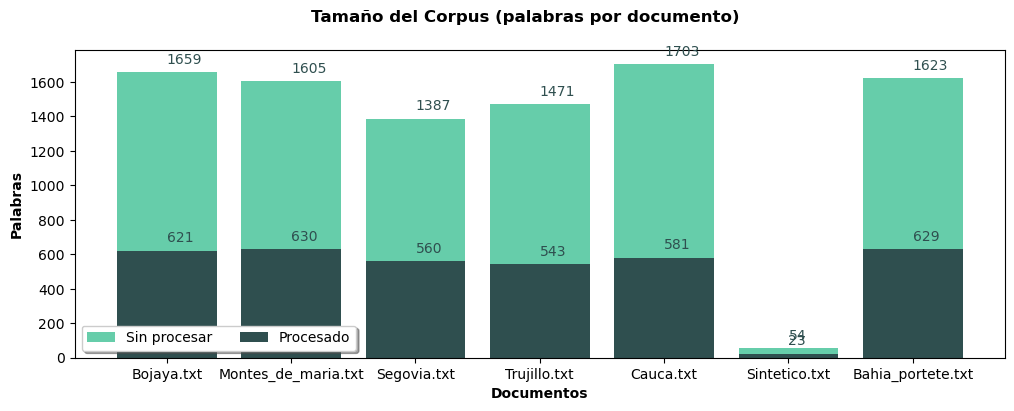

In [27]:
# Grafica de dimensión de corpus por testimonio (palabras por documento)
# Si el número de testimonios supera los 15 pasa de barras a líneas

plt.figure(figsize=(len(lista_archivos)+5, 4))
if len(lista_archivos) > 15:
    plt.plot(lista_archivos,palabra_documento, color = "mediumaquamarine", label = "Sin procesar")
    plt.plot(lista_archivos,tamapalabra_documento, color = "darkslategray", label = "Procesado")
    plt.legend(fontsize=10, shadow=True, ncol=2, loc=6)
else:
    plt.bar(lista_archivos,palabra_documento, color = "mediumaquamarine", label = "Sin procesar")
    plt.xlabel("Documentos", weight='bold')
    plt.ylabel("Palabras", weight='bold')
    plt.bar(lista_archivos,tamapalabra_documento, color = "darkslategray", label = "Procesado")
    plt.legend(fontsize=10, shadow=True, ncol=2, loc=3)
plt.suptitle("Tamaño del Corpus (palabras por documento)", weight='bold')
for i,j in zip(lista_archivos,palabra_documento):
    plt.annotate(j,xy=(i,j+50),color="darkslategray")
for i,j in zip(lista_archivos,tamapalabra_documento):
    plt.annotate(j,xy=(i,j+50),color="darkslategray")
plt.show()

In [28]:
# Comparación de testimonios en corpus por caracteres

dfcomparacorpusnuevo = pd.DataFrame({"Archivo":lista_archivos,"Testimonio base":tamanocorpus, 
                                     "Testimonio limpio":tamanocorpuslimpio, "Diferencia": tot_dif_corpus,
                                    "% Dif":porc_dif_corpus})

dfcomparacorpusnuevo

,Archivo,Testimonio base,Testimonio limpio,Diferencia,% Dif
0,Bojaya.txt,8822,4635,4187,47.46
1,Montes_de_maria.txt,9059,5081,3978,43.91
2,Segovia.txt,7932,4498,3434,43.29
3,Trujillo.txt,8211,4422,3789,46.15
4,Cauca.txt,8974,4498,4476,49.88
5,Sintetico.txt,309,208,101,32.69
6,Bahia_portete.txt,8959,4774,4185,46.71


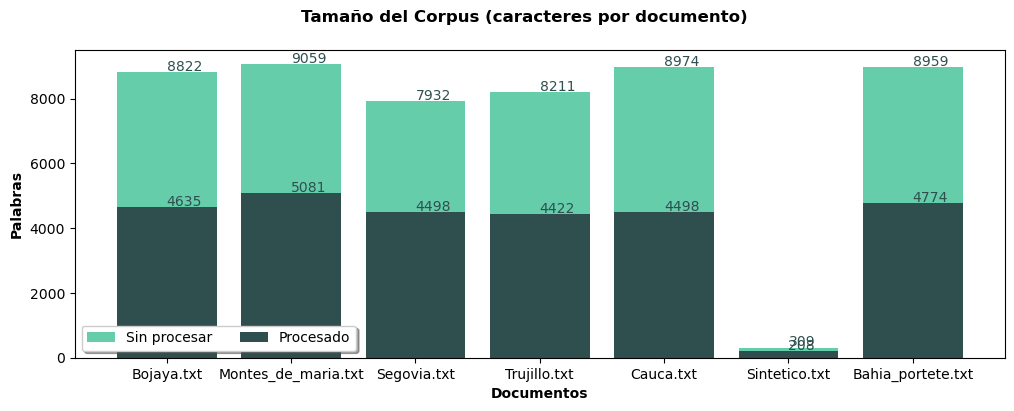

In [29]:
# Grafica de dimensión de corpus por testimonio (caracteres por documento)
# Si el número de testimonios supera los 15 pasa de barras a líneas

plt.figure(figsize=(len(lista_archivos)+5, 4))
if len(lista_archivos) > 15:
    plt.plot(lista_archivos,tamanocorpus, color = "mediumaquamarine", label = "Sin procesar")
    plt.plot(lista_archivos,tamanocorpuslimpio, color = "darkslategray", label = "Procesado")
    plt.legend(fontsize=10, shadow=True, ncol=2, loc=6)
else:
    plt.bar(lista_archivos,tamanocorpus, color = "mediumaquamarine", label = "Sin procesar")
    plt.xlabel("Documentos", weight='bold')
    plt.ylabel("Palabras", weight='bold')
    plt.bar(lista_archivos,tamanocorpuslimpio, color = "darkslategray", label = "Procesado")
    plt.legend(fontsize=10, shadow=True, ncol=2, loc=3)
plt.suptitle("Tamaño del Corpus (caracteres por documento)", weight='bold')
for i,j in zip(lista_archivos,tamanocorpus):
    plt.annotate(j,xy=(i,j+50),color="darkslategray")
for i,j in zip(lista_archivos,tamanocorpuslimpio):
    plt.annotate(j,xy=(i,j+50),color="darkslategray")
plt.show()

In [ ]:
# Exportar a excel comparación de documentos preprocesados
# dftamanocorpusnuevo.to_excel("output.xlsx", sheet_name='testimonios')

In [30]:
# Lista de corpus procesado para obtener relaciones con diccionarios de dimensiones
df_corpuslimpio = pd.DataFrame({"Testimonio":corpuslimpio})
df_corpuslimpio = df_corpuslimpio.to_numpy().tolist()

In [31]:
# Ampliación del corpus con lista de palabras para buscar en dimensiones
# Se hizo un bag of words con un n-grama en relación 1 a 3
corpus_ampliado=[]
for testimonio in df_corpuslimpio:
    palabras_testimonio = CountVectorizer(ngram_range=(1,3))
    palabras_testimonio_matrix = palabras_testimonio.fit_transform(testimonio)
    palabras_testimonio_matrix = palabras_testimonio_matrix.toarray()
    palabras_testimonio_matrix = palabras_testimonio_matrix[0,:]
    palabras_testimonio_matrix = palabras_testimonio_matrix.tolist()
    nombre_palabras = palabras_testimonio.get_feature_names_out()
    testimonio_ampliado=[]
    for pal,cant in zip (nombre_palabras,palabras_testimonio_matrix):
        for multi in range(cant):
            testimonio_ampliado.append(pal)
    corpus_ampliado.append(testimonio_ampliado)

# Identificación de elementos comunes según diccionarios

In [32]:
# Filtro final de palabras del documento que coinciden con los diccionarios 
# Se llevan a variables solo las palabras que coinciden

busq_ubic = []
busq_victm = []
busq_afec = []
busq_tempo = []
busq_enti = []

for u in corpus_ampliado:
    dm_temp = [fp for fp in u if fp in lista_ubicaciones]
    busq_ubic.append(dm_temp)
    dm_temp2 = [fp for fp in u if fp in lista_hecho_victimizante]
    busq_victm.append(dm_temp2)
    dm_temp3 = [fp for fp in u if fp in lista_afectacion]
    busq_afec.append(dm_temp3)
    dm_temp2 = [fp for fp in u if fp in lista_temporalidad]
    busq_tempo.append(dm_temp2)
    dm_temp3 = [fp for fp in u if fp in lista_entidades]
    busq_enti.append(dm_temp3)

In [33]:
# Nuevo DF resultado de la búsqueda en las dimensiones
realizados = pd.DataFrame({"documento":lista_archivos,"Ubicaciones":busq_ubic,"Hecho Victimizante":busq_victm,"Afectación":busq_afec,"Temporalidad":busq_tempo,"Entidades":busq_enti})
#realizados = pd.DataFrame({"Ubicaciones":busq_ubic,"Hecho Victimizante":busq_victm,"Afectación":busq_afec,"Temporalidad":busq_tempo,"Entidades":busq_enti})
realizados

,documento,Ubicaciones,Hecho Victimizante,Afectación,Temporalidad,Entidades
0,Bojaya.txt,"[bellavista, bellavista, bellavista, carretera, carrillo, casa, casa, casa, casa, casa, casa, casa, casa, casa, casa, casa cural, casa cural, casa cural, casa cural, casas, centro salud, centro salud, centro salud, chocó, colegio, colombia, departamento, iglesia, iglesia, iglesia, iglesia, iglesia, iglesia, iglesia, iglesia, iglesia, iglesia, iglesia, mares, medellín, mosquera, municipio, municipio, necoclí, noroeste, orilla, panamericana, región, región, región, región, restaurante, río, universidad, urgencias, vigía fuerte, vigía fuerte, vigía fuerte, vigía fuerte, zona, zona]","[bomba, cilindro, cilindro, cilindro bomba, combate, conflicto, daba, destrozo, explosión, masacre, masacre, masacre, masacre, matar, pipeta, refugiados]","[cáncer, esquirlas, herida, herida, herida, heridos, heridos, muerto, muerto, muerto, necesario, salud, salud, salud, secuelas]","[marzo, mayo, mayo, mayo, mayo, mayo, mayo, mayo, mayo, mayo, octubre]","[abuela, abuela, abuela, abuela, aliciente, antún ramos, auria, autoridades, auxiliar, auxiliar, bloque 58, camilo, civiles, comandante, comandante, enfermera, enfermera, enfermera, farc, farc, farc, guerrilla, guerrilla, guerrilla, guerrilla, guerrilla, joven, mamá, mamá, menores, misioneras agustinas, monjas, monjas, muerto, muerto, muerto, niña, paciente, padre, padre, padre, papá, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, personas, personas, vecino]"
1,Montes_de_maria.txt,"[barrio, bolívar, bolívar, bolívar, cairo, caribe, carmen, carmen, carmen, carmen bolívar, carmen bolívar, cartagena, cartagena, casa, casa, casa, casa, casa, casa, casa, casa cultura, casa cultura, casa cultura, colombia, colombia, concejo municipal, escuela, ferretería, mercado viejo, montes maría, montes maría, montes maría, montes maría, montes maría, montes maría, municipio, parque, paz, país, porvenir, pueblo, pueblo, pueblo, pueblo, pueblo, región, región, región, salado, salado, salado, salado, sucre, vereda, zona, zona, zona]","[asentaron, bomba, bomba, bomba, bomba, complot, conflicto, conflicto, conflicto, conflicto, desplazados, desplazados, desplazamiento, guerra, lucha, masacre, masacre, matar, matar, secuestrar, sevicia, sevicia, toque queda]","[accidente, asesinados, carencia, memoria, memoria, memoria, memoria, miedo, miedo, miedo, muertos, muertos, noche, noche negra, quemaduras]","[agosto, febrero, julio, lunes, mayo, miércoles, octubre, septiembre]","[alcalde, amigas, amigos, amigos, autodefensas unidas colombia, beatriz, beatriz, beatriz, bloque norte, chichi, chichi, civiles, colectivo, colectivo, colectivo, colectivo, colectivo, colectivo, colectivo, colombiano, comunicadores, concejales, dueño, farc, frente 37, fuerzas armadas colombia, fulano, guerrilla, guerrilla, guerrilla, guerrilla, guerrilla, hermano, hermano, hermano, jorge, maestros, mamá, muertos, muertos, museo itinerante memoria, museo itinerante memoria, paracos, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, paramilitares, personas, personas, personas, personas, personas, policía, policía, sijin, soraya bayuelo, tía]"
2,Segovia.txt,"[antioquia, campo, campo, casa, casa, casa, casa, casas, casas, cementerio, ciudad, colombia, colombia, departamento, escuela, heladería, heladería, iglesia, iglesia, iglesia, iglesia, kiosco, municipio, murillo, occidente, parque, parque, parque, plaza, pueblo, pueblo, pueblo, región, remedios, segovia, segovia, segovia, segovia, segovia, segovia, segovia, segovia, segovia, segovia, segovia, universidad, unión]","[conciencia social, disparos, disparos, disparos, guerra, heridas, masacre, masacre, masacre, masacre, masacre, masacre, operación contrainsurgente, partido, partido, tiros, tiros, tiros, toma, toma, toma guerrillera, toma guerrillera, toque queda, violencia políti

# Relaciones

In [34]:
# Función para unificar valores y contar frecuencias
# devuelve dos variables
def unificarfrecuencias(objeto):
    Val_Unic = []
    Cont_Unic = []
    for sublista in objeto:
        Val_Unic_tmp = []
        Cont_Val_tmp = []
        for item in sublista:
            if item not in Val_Unic_tmp:
                Val_Unic_tmp.append(item)
                Cont_Val_tmp.append(sublista.count(item))
        Val_Unic.append(Val_Unic_tmp)
        Cont_Unic.append(Cont_Val_tmp)
    return Val_Unic, Cont_Unic

In [35]:
# Limpieza de elementos
# Unificación de elementos y su peso o frecuencia

unic_ubic, cont_ubic = unificarfrecuencias(busq_ubic)
unic_victm, cont_victm = unificarfrecuencias(busq_victm)
unic_afec, cont_afec = unificarfrecuencias(busq_afec)
unic_tempo, cont_tempo = unificarfrecuencias(busq_tempo)
unic_enti, cont_enti = unificarfrecuencias(busq_enti)

In [36]:
# DF para generar el grafo de relaciones
# Elementos únicos por cada dimensión
# No se incluye el nombre del archivo
pararelaciones = pd.DataFrame({"Ubicaciones":unic_ubic,"Hecho Victimizante":unic_victm,"Afectación":unic_afec,"Temporalidad":unic_tempo,"Entidades":unic_enti})
pararelaciones

,Ubicaciones,Hecho Victimizante,Afectación,Temporalidad,Entidades
0,"[bellavista, carretera, carrillo, casa, casa cural, casas, centro salud, chocó, colegio, colombia, departamento, iglesia, mares, medellín, mosquera, municipio, necoclí, noroeste, orilla, panamericana, región, restaurante, río, universidad, urgencias, vigía fuerte, zona]","[bomba, cilindro, cilindro bomba, combate, conflicto, daba, destrozo, explosión, masacre, matar, pipeta, refugiados]","[cáncer, esquirlas, herida, heridos, muerto, necesario, salud, secuelas]","[marzo, mayo, octubre]","[abuela, aliciente, antún ramos, auria, autoridades, auxiliar, bloque 58, camilo, civiles, comandante, enfermera, farc, guerrilla, joven, mamá, menores, misioneras agustinas, monjas, muerto, niña, paciente, padre, papá, paramilitares, personas, vecino]"
1,"[barrio, bolívar, cairo, caribe, carmen, carmen bolívar, cartagena, casa, casa cultura, colombia, concejo municipal, escuela, ferretería, mercado viejo, montes maría, municipio, parque, paz, país, porvenir, pueblo, región, salado, sucre, vereda, zona]","[asentaron, bomba, complot, conflicto, desplazados, desplazamiento, guerra, lucha, masacre, matar, secuestrar, sevicia, toque queda]","[accidente, asesinados, carencia, memoria, miedo, muertos, noche, noche negra, quemaduras]","[agosto, febrero, julio, lunes, mayo, miércoles, octubre, septiembre]","[alcalde, amigas, amigos, autodefensas unidas colombia, beatriz, bloque norte, chichi, civiles, colectivo, colombiano, comunicadores, concejales, dueño, farc, frente 37, fuerzas armadas colombia, fulano, guerrilla, hermano, jorge, maestros, mamá, muertos, museo itinerante memoria, paracos, paramilitares, personas, policía, sijin, soraya bayuelo, tía]"
2,"[antioquia, campo, casa, casas, cementerio, ciudad, colombia, departamento, escuela, heladería, iglesia, kiosco, municipio, murillo, occidente, parque, plaza, pueblo, región, remedios, segovia, universidad, unión]","[conciencia social, disparos, guerra, heridas, masacre, operación contrainsurgente, partido, tiros, toma, toma guerrillera, toque queda, violencia política]","[dormía, extraño, miedo, miedo extraño, miedo noche, muerto, muertos, noche, olvido, recobrar libertad, secuelas, terror, violencia]","[11 noche, domingo, enero, lunes, noviembre]","[amigos, banda marcial, batallón, civiles, comité amenazados, comité derechos humanos, empresa minera, familias, fernando, guerrero, izquierda, mamá, marcos, minero, moir, muerto, muertos, nando, palagua murillo, papá, paramilitares, personas, policía, profe, profesor, revolucionarios nordeste, roberto, sindicato, tropas, unión patriótica, vecino]"
3,"[bolívar, casas, cauca, colombia, cuartel, departamento, dolores, finca, iglesia, noroccidente, occidente, parque, parque monumento, pueblo, roldanillo, río, sur occidente, trujillo, une, unión, valle cauca]","[asesinado, ataque, cogía pared, daba, homicidio, lucha, masacre, perseguía, profanado tumbas, separamos, sevicia, tortura, torturado, violencia política]","[accidente, asesinados, denuncias, descuido, descuido estatal, desespero, dificultades, dolores, duelo, enloquecer, falta vías, manifestación, memoria, olvido, salud, tranquilo, violencia]","[12, abril, febrero]","[alba mery chilito, amigas, campesinos, colombiano, compañero, defensora, eln, empresas comunitarias, ernesto samper, familias, frankie, funeraria, guerrilla, jorge, ludivia, líder, mamá, militares, mujer, muñeco, narcotraficantes, niña, oea, padre, papá, paramilitares, partera, policía, religiosa, terratenientes, tiberio fernández, vecino]"
4,"[caloto, calvario, casa, casas, cauca, colegio, colombia, departamento, escuela, finca, municipio, occidente, paz, plata, sur occidente, suroccidente, vereda]","[atentado, daba, desplazamiento, regresar]","[dormía, noche, ropa, violencia]",[],"[colombiano, indígena, mamá, mujer, papá]"
5,"[municipio, región, segovia]",[masacre],"[muerto, violencia]",[],"[muerto, profe]"
6,"[bahía portete, carmen, casa, casas, cementerio, colombi

In [37]:
# Función para encontrar la longitud de las listas de cada dimensión por documento
# Una por las frecuencias y otra para los elementos únicos
def frecuencialemento(dimfreccomp, dimens):
    cuentadimensfrec= []
    for elemfrec in dimfreccomp:
        cuentadimensfrec.append(len(elemfrec))
    # return cuentadimensfrec
    
    cuentadimens= []
    for elem in dimens:
        cuentadimens.append(len(elem))
    return cuentadimensfrec, cuentadimens

# Obtención de frecuencias en listas
frec_busq_ubic, frec_unic_ubic= frecuencialemento(busq_ubic, unic_ubic)
frec_busq_victm, frec_unic_victm = frecuencialemento(busq_victm, unic_victm)
frec_busq_afec, frec_unic_afec = frecuencialemento(busq_afec, unic_afec)
frec_busq_tempo, frec_unic_tempo = frecuencialemento(busq_tempo, unic_tempo)
frec_busq_enti, frec_unic_enti = frecuencialemento(busq_enti, unic_enti)

In [38]:
# Dataframe comparativo de amplitud de dimensiones ataframe comparativo de amplitud de 
dfcomparaelementos = pd.DataFrame({"Archivo":lista_archivos,"Ubicaciones":frec_busq_ubic,"Ubic. Únicas":frec_unic_ubic,
                                  "Hechos":frec_busq_victm,"H. Únicas":frec_unic_victm,
                                  "Afectaciones":frec_busq_afec,"Afect. Únicas":frec_unic_afec,
                                  "Temporal":frec_busq_tempo,"Temp. Únicas":frec_unic_tempo,
                                  "Entidades":frec_busq_enti,"Ent. Únicas":frec_unic_enti,})
dfcomparaelementos

,Archivo,Ubicaciones,Ubic. Únicas,Hechos,H. Únicas,Afectaciones,Afect. Únicas,Temporal,Temp. Únicas,Entidades,Ent. Únicas
0,Bojaya.txt,61,27,16,12,15,8,11,3,54,26
1,Montes_de_maria.txt,57,26,23,13,15,9,8,8,61,31
2,Segovia.txt,47,23,24,12,24,13,8,5,52,31
3,Trujillo.txt,37,21,19,14,24,17,3,3,73,32
4,Cauca.txt,31,17,4,4,6,4,0,0,21,5
5,Sintetico.txt,9,3,1,1,2,2,0,0,2,2
6,Bahia_portete.txt,70,21,16,11,16,9,9,5,76,33


In [39]:
# Identificación de nombres y códigos de documentos y dimensiones
id_documento = []
nombre_documento = []
id_dimension = []
nombre_dimension = []

for M, dime in enumerate(realizados):
    if M == 0:
        for d, doc in enumerate(realizados.iloc[:,M]):
            id_doc = "D"+str(d)
            id_documento.append(id_doc)
            nombre_documento.append(doc)
    else:
        for d, doc in enumerate(realizados.iloc[:,M]):
            id_dim = "D"+str(d)+"M"+str(M-1)
            id_dimension.append(id_dim)
            nombre_dimension.append(dime)

In [40]:
# DataFrame de Documento
cod_doc = pd.DataFrame({"Código":id_documento,"Documento":nombre_documento})
cod_doc

,Código,Documento
0,D0,Bojaya.txt
1,D1,Montes_de_maria.txt
2,D2,Segovia.txt
3,D3,Trujillo.txt
4,D4,Cauca.txt
5,D5,Sintetico.txt
6,D6,Bahia_portete.txt


In [41]:
# DataFrame de Dimension
cod_dim = pd.DataFrame({"Código":id_dimension,"Dimensión":nombre_dimension})
cod_dim

,Código,Dimensión
0,D0M0,Ubicaciones
1,D1M0,Ubicaciones
2,D2M0,Ubicaciones
3,D3M0,Ubicaciones
4,D4M0,Ubicaciones
5,D5M0,Ubicaciones
6,D6M0,Ubicaciones
7,D0M1,Hecho Victimizante
8,D1M1,Hecho Victimizante
9,D2M1,Hecho Victimizante


In [42]:
# Función para determinar la relación de cada ítem entre su dimensión
# También para relacionar la dimensión con el documento
# Considerando las dimensiones a partir de un DF resultado del filtro de palabras por dimensión
# Recibe el DF y entrega cuatro variables con listas de tuplas:
# Variable 1 (Rel_DocDimEle_DocEle): es la relación de elemento de cada documento por dimensión con la dimensión de cada documento
# Variable 2 (Rel_DocDim_Doc): la relación entre la dimensión de cada documento y su documento,
# Variables 3 y 4 (id_elemento y nombre_elemento): Son el código y el nombre de cada elemento

def relcompleto(listado):
    Rel_DocDimEle_DocEle = []
    Rel_DocDim_Doc = []
    id_elemento = []
    nombre_elemento = []
    for M, dime in enumerate(listado):
        for d, doc in enumerate(listado.iloc[:,M]):
            for i, item in enumerate(doc):
                a = "D"+str(d)+"M"+str(M)+"E"+str(i)
                b = "D"+str(d)+"M"+str(M)
                c = "D"+str(d)
                Rel_DocDimEle_DocEle.append((a,b))
                Rel_DocDim_Doc.append((b,c))
                id_elemento.append(a)
                nombre_elemento.append(item)
            Rel_DocDim_Doc = list(set(Rel_DocDim_Doc))
    return Rel_DocDimEle_DocEle, Rel_DocDim_Doc, id_elemento, nombre_elemento

In [44]:
# Obtener relaciones directas por jerarquía
relacionesdirectas_ord1, relacionesdirectas_ord2, id_elemento, nombre_elemento = relcompleto(pararelaciones)
#relacionesdirectas_ord1

In [45]:
# DataFrame de Elemento
cod_ele = pd.DataFrame({"Código":id_elemento,"Elemento":nombre_elemento})
cod_ele

,Código,Elemento
0,D0M0E0,bellavista
1,D0M0E1,carretera
2,D0M0E2,carrillo
3,D0M0E3,casa
4,D0M0E4,casa cural
...,...,...
446,D6M4E28,rey
447,D6M4E29,secretaría asuntos indígenas
448,D6M4E30,simón barros epieyu
449,D6M4E31,tía


In [46]:
# Función que obtiene las interrelaciones entre los términos de todos los documentos de la misma dimensión
# Recibe como parámetro el DF del listado de términos discriminados

def relintraitem(listado):
    EntreItems = []
    EntreDocs = []
    for M, dime in enumerate(listado):
        for d, doc in enumerate(listado.iloc[:,M]):
            D = d
            for i, item in enumerate(doc):
                v = D+1
                for j, sublist in enumerate(listado.iloc[v:,M]):
                    for k, subitem in enumerate(sublist):
                        if item == subitem:
                            a = "D"+str(D)+"M"+str(M)+"E"+str(i)
                            b = "D"+str(D+j+1)+"M"+str(M)+"E"+str(k)
                            c = "D"+str(D)
                            e = "D"+str(D+j+1)
                            EntreItems.append((a,b))
                            EntreDocs.append((c,e))
    #Relaciones inter documentos deshabilitadas
    EntreDocs = list(set(EntreDocs)) # Relación entre documentos
    EntreItems = EntreItems + EntreDocs # Relación entre documentos
    return EntreItems

In [47]:
# Obtiene relaciones los ítem de los documentos de una misma dimensión
relacionesentreitems = relintraitem(pararelaciones)
relacionesentreitems

[('D0M0E3', 'D1M0E7'),
 ('D0M0E3', 'D2M0E2'),
 ('D0M0E3', 'D4M0E2'),
 ('D0M0E3', 'D6M0E2'),
 ('D0M0E5', 'D2M0E3'),
 ('D0M0E5', 'D3M0E1'),
 ('D0M0E5', 'D4M0E3'),
 ('D0M0E5', 'D6M0E3'),
 ('D0M0E8', 'D4M0E5'),
 ('D0M0E9', 'D1M0E9'),
 ('D0M0E9', 'D2M0E6'),
 ('D0M0E9', 'D3M0E3'),
 ('D0M0E9', 'D4M0E6'),
 ('D0M0E9', 'D6M0E5'),
 ('D0M0E10', 'D2M0E7'),
 ('D0M0E10', 'D3M0E5'),
 ('D0M0E10', 'D4M0E7'),
 ('D0M0E11', 'D2M0E10'),
 ('D0M0E11', 'D3M0E8'),
 ('D0M0E15', 'D1M0E15'),
 ('D0M0E15', 'D2M0E12'),
 ('D0M0E15', 'D4M0E10'),
 ('D0M0E15', 'D5M0E0'),
 ('D0M0E15', 'D6M0E12'),
 ('D0M0E20', 'D1M0E21'),
 ('D0M0E20', 'D2M0E18'),
 ('D0M0E20', 'D5M0E1'),
 ('D0M0E22', 'D3M0E15'),
 ('D0M0E23', 'D2M0E21'),
 ('D0M0E26', 'D1M0E25'),
 ('D0M0E26', 'D6M0E20'),
 ('D1M0E1', 'D3M0E0'),
 ('D1M0E4', 'D6M0E1'),
 ('D1M0E7', 'D2M0E2'),
 ('D1M0E7', 'D4M0E2'),
 ('D1M0E7', 'D6M0E2'),
 ('D1M0E9', 'D2M0E6'),
 ('D1M0E9', 'D3M0E3'),
 ('D1M0E9', 'D4M0E6'),
 ('D1M0E9', 'D6M0E5'),
 ('D1M0E11', 'D2M0E8'),
 ('D1M0E11', 'D4M0E8'),
 ('D

# Similitud 

In [48]:
# Se unifican nuevamente las dimensiones por cada documento para la búsqueda de similitud

corpus_filtrado = [a + b + c + d + e for a, b, c, d, e in zip(busq_ubic, busq_victm, busq_afec, busq_tempo, busq_enti)]
testim=[]
for testimonio in corpus_filtrado:
    archivo = " ".join(testimonio)
    testim.append(archivo)
    
#corpus_filtrado

In [49]:
# Comparación de datos después de filtrado por palabras
tamanocorpusfiltrado =[len(amp) for amp in testim]
tottamanocorpusfiltrado = sum(tamanocorpusfiltrado)

palatamanocorpusfiltrado =[len(elemento.split()) for elemento in testim]
palatottamanocorpusfiltrado = sum(palatamanocorpusfiltrado)

dfcomparacorpusnuevopala = pd.DataFrame({"Archivo":lista_archivos,"Testimonio base":palabra_documento, 
                                     "Testimonio limpio":tamapalabra_documento, "Testimonio Filtrado": palatamanocorpusfiltrado})
dfcomparacorpusnuevopala 

,Archivo,Testimonio base,Testimonio limpio,Testimonio Filtrado
0,Bojaya.txt,1659,621,172
1,Montes_de_maria.txt,1605,630,190
2,Segovia.txt,1387,560,173
3,Trujillo.txt,1471,543,171
4,Cauca.txt,1703,581,63
5,Sintetico.txt,54,23,14
6,Bahia_portete.txt,1623,629,213


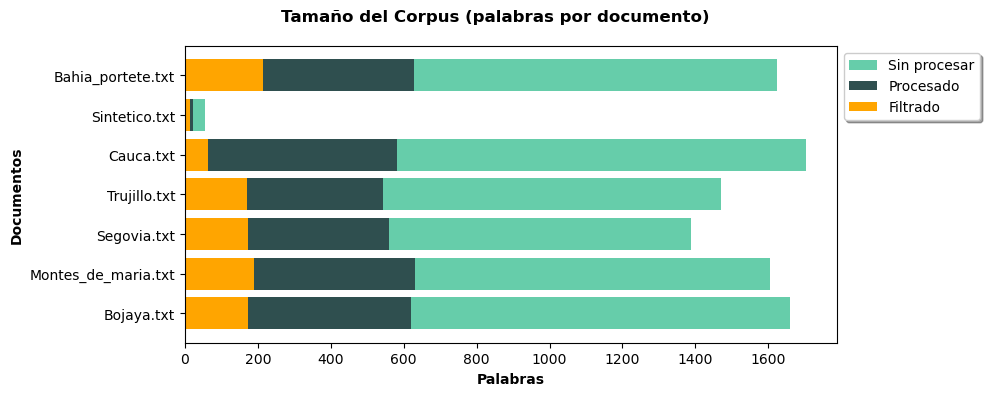

In [50]:
# Grafica de dimensión de corpus por testimonio comparando los tres niveles
# Si el número de testimonios supera los 15 pasa de barras a líneas

plt.figure(figsize=(len(lista_archivos)+3, 4))

if len(lista_archivos) > 15:
    plt.plot(lista_archivos,palabra_documento, color = "mediumaquamarine", label = "Sin procesar")
    plt.plot(lista_archivos,tamapalabra_documento, color = "darkslategray", label = "Procesado")
    plt.plot(lista_archivos,palatamanocorpusfiltrado, color = "orange", label = "Filtrado")
    plt.legend(fontsize=10, shadow=True, ncol=2, loc=6)
else:
    plt.barh(lista_archivos,palabra_documento, color = "mediumaquamarine", label = "Sin procesar")
    plt.barh(lista_archivos,tamapalabra_documento, color = "darkslategray", label = "Procesado")
    plt.barh(lista_archivos,palatamanocorpusfiltrado, color = "orange", label = "Filtrado")
    #plt.legend(fontsize=10, shadow=True, ncol=2, loc=1)
plt.suptitle("Tamaño del Corpus (palabras por documento)", weight='bold')
plt.xlabel("Palabras", weight='bold')
plt.ylabel("Documentos", weight='bold')
#for i,j in zip(lista_archivos,tamanocorpus):
#    plt.annotate(j,xy=(i,j+50),color="darkslategray")
#for i,j in zip(lista_archivos,tamanocorpuslimpio):
#    plt.annotate(j,xy=(i,j+50),color="darkslategray")
#for i,j in zip(lista_archivos,tamanocorpusfiltrado):
#    plt.annotate(j,xy=(i,j+50),color="orange")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10, shadow=True)
plt.tight_layout()
plt.show()

In [51]:
# Comparación de datos después de filtrado por caracteres
tamanocorpusfiltrado =[len(amp) for amp in testim]
tottamanocorpusfiltrado = sum(tamanocorpusfiltrado)

dfcomparacorpusnuevo = pd.DataFrame({"Archivo":lista_archivos,"Testimonio base":tamanocorpus, 
                                     "Testimonio limpio":tamanocorpuslimpio, "Testimonio Filtrado": tamanocorpusfiltrado})
dfcomparacorpusnuevo 

,Archivo,Testimonio base,Testimonio limpio,Testimonio Filtrado
0,Bojaya.txt,8822,4635,1327
1,Montes_de_maria.txt,9059,5081,1511
2,Segovia.txt,7932,4498,1373
3,Trujillo.txt,8211,4422,1377
4,Cauca.txt,8974,4498,432
5,Sintetico.txt,309,208,110
6,Bahia_portete.txt,8959,4774,1601


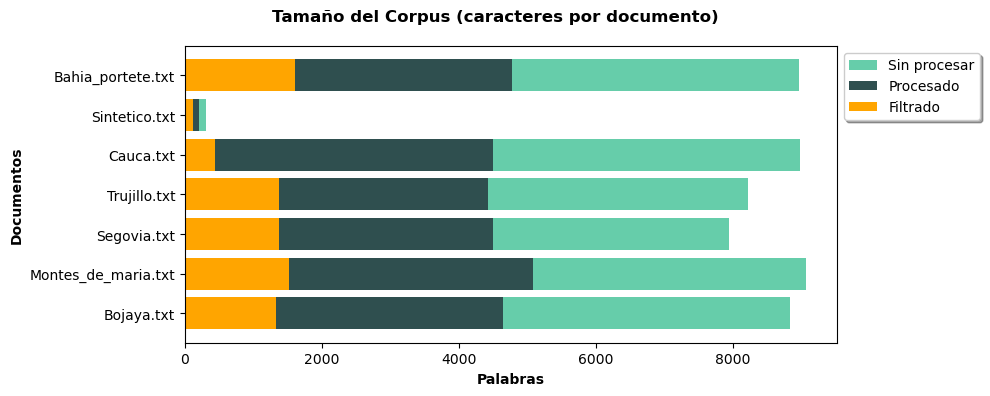

In [52]:
# Grafica de dimensión de corpus por testimonio comparando los tres niveles
# Si el número de testimonios supera los 15 pasa de barras a líneas

plt.figure(figsize=(len(lista_archivos)+3, 4))

if len(lista_archivos) > 15:
    plt.plot(lista_archivos,tamanocorpus, color = "mediumaquamarine", label = "Sin procesar")
    plt.plot(lista_archivos,tamanocorpuslimpio, color = "darkslategray", label = "Procesado")
    plt.plot(lista_archivos,tamanocorpusfiltrado, color = "orange", label = "Filtrado")
    plt.legend(fontsize=10, shadow=True, ncol=2, loc=6)
else:
    plt.barh(lista_archivos,tamanocorpus, color = "mediumaquamarine", label = "Sin procesar")
    plt.barh(lista_archivos,tamanocorpuslimpio, color = "darkslategray", label = "Procesado")
    plt.barh(lista_archivos,tamanocorpusfiltrado, color = "orange", label = "Filtrado")
    #plt.legend(fontsize=10, shadow=True, ncol=2, loc=1)
plt.suptitle("Tamaño del Corpus (caracteres por documento)", weight='bold')
plt.xlabel("Palabras", weight='bold')
plt.ylabel("Documentos", weight='bold')
#for i,j in zip(lista_archivos,tamanocorpus):
#    plt.annotate(j,xy=(i,j+50),color="darkslategray")
#for i,j in zip(lista_archivos,tamanocorpuslimpio):
#    plt.annotate(j,xy=(i,j+50),color="darkslategray")
#for i,j in zip(lista_archivos,tamanocorpusfiltrado):
#    plt.annotate(j,xy=(i,j+50),color="orange")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=10, shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
# NO SE REQUIERE EJECUTAR
# Se obtienen las palabras individuales para hacer el análisis de la bolsa de palabras
# Contador de frecuencias
cont_freq = CountVectorizer(min_df=0., max_df=1.)
# Cuenta las frecuencias de cada palabra 
matriz_freq = cont_freq.fit_transform(testim)
# Visualizar el resumen y tamaño de la matriz
#matriz_freq
# Visualiza las frecuencias de términos en matriz dispersa
#print(matriz_freq)

In [ ]:
# NO SE REQUIERE EJECUTAR
# Transforma matriz en array
matriz_freq_array = matriz_freq.toarray()
matriz_freq_array

In [ ]:
# NO SE REQUIERE EJECUTAR
# Se muestra con mejor apariencia
etiquetas = cont_freq.get_feature_names()
# show document feature vectors
pd.DataFrame(matriz_freq_array, columns=etiquetas)

In [53]:
# Tfidf - Medida de documento inverso
# Identificación de los elementos de cada testimonio y su relación con el documento utilizando la técnica tf_idf

identificador = TfidfVectorizer(ngram_range=(1, 3), min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
mapa_elementos = identificador.fit_transform(testim)
mapa_elementos = mapa_elementos.toarray()

etiq = identificador.get_feature_names_out()
pd.DataFrame(np.round(mapa_elementos, 2), columns=etiq)

,11,11 noche,11 noche domingo,12,12 abril,12 abril febrero,37,37 fuerzas,37 fuerzas armadas,58,...,zona brazo,zona brazo calcinado,zona zona,zona zona asentaron,zona zona bomba,zona zona brazo,zona zona zona,éxodo,éxodo accidente,éxodo accidente asesinados
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,...,0.00,0.00,0.02,0.00,0.03,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.03,0.03,0.00,...,0.00,0.00,0.04,0.03,0.00,0.00,0.03,0.00,0.00,0.00
2,0.03,0.03,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.03,0.03,0.03,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.02,0.02,0.01,0.00,0.00,0.02,0.00,0.02,0.02,0.02


In [54]:
# Se mide la distancia con la Similitud de Coseno
similaridad = cosine_similarity(mapa_elementos)
df_similaridad = pd.DataFrame(similaridad)
df_similaridad

,0,1,2,3,4,5,6
0,1.000000,0.208267,0.116921,0.050531,0.066732,0.022669,0.032190
1,0.208267,1.000000,0.125055,0.060430,0.050402,0.005789,0.103144
2,0.116921,0.125055,1.000000,0.073544,0.056693,0.430825,0.062897
3,0.050531,0.060430,0.073544,1.000000,0.065406,0.007621,0.008395
4,0.066732,0.050402,0.056693,0.065406,1.000000,0.004165,0.015559
5,0.022669,0.005789,0.430825,0.007621,0.004165,1.000000,0.007152
6,0.032190,0.103144,0.062897,0.008395,0.015559,0.007152,1.000000


# Gráficos

In [55]:
# Análisis de similitd a partir de matriz de dendograma
tabla_dendograma = linkage(similaridad, 'ward')
pd.DataFrame(tabla_dendograma, columns=['Enlace A', 'Enlace B', 
                         'Distancia', 'Tamaño de cluster'], dtype='object')

,Enlace A,Enlace B,Distancia,Tamaño de cluster
0,2.0,5.0,0.825372,2.0
1,0.0,1.0,1.122244,2.0
2,3.0,4.0,1.321985,2.0
3,6.0,8.0,1.392766,3.0
4,9.0,10.0,1.460579,5.0
5,7.0,11.0,1.775192,7.0


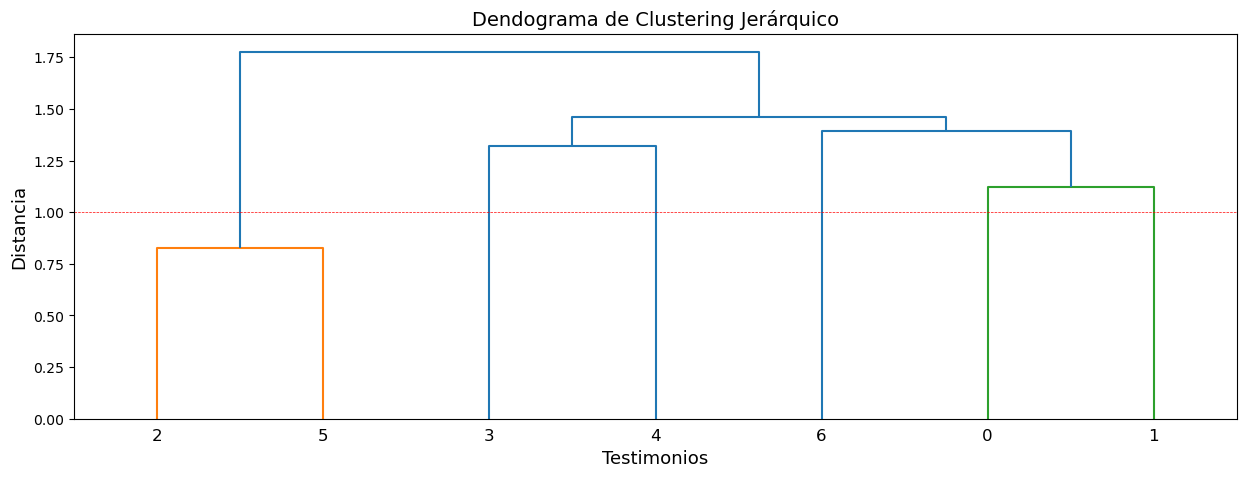

In [56]:
# Gráfico en dendograma
plt.figure(figsize=(15, 5))
plt.title('Dendograma de Clustering Jerárquico',fontsize=14)
plt.xlabel('Testimonios', fontsize=13)
plt.ylabel('Distancia', fontsize=13)
dendrogram(tabla_dendograma)
plt.axhline(y=1, c='red', ls='--', lw=0.5)

In [57]:
# DF para generar el grafo de relaciones
# Frecuencia o peso de cada elemento por dimensión
# No se incluye el nombre del archivo
frecpararelaciones = pd.DataFrame({"Ubicaciones":cont_ubic,"Hecho Victimizante":cont_victm,"Afectación":cont_afec,"Temporalidad":cont_tempo,"Entidades":cont_enti})
frecpararelaciones

,Ubicaciones,Hecho Victimizante,Afectación,Temporalidad,Entidades
0,"[3, 1, 1, 10, 4, 1, 3, 1, 1, 1, 1, 11, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 2]","[1, 2, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1]","[1, 1, 3, 2, 3, 1, 3, 1]","[1, 9, 1]","[4, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3, 3, 5, 1, 2, 1, 1, 2, 3, 1, 1, 3, 1, 9, 2, 1]"
1,"[1, 3, 1, 1, 3, 2, 2, 7, 3, 2, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 5, 3, 4, 1, 1, 3]","[1, 4, 1, 4, 2, 1, 1, 1, 2, 2, 1, 2, 1]","[1, 1, 1, 4, 3, 2, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 2, 1, 3, 1, 2, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 1, 1, 1, 2, 2, 1, 8, 5, 2, 1, 1, 1]"
2,"[1, 2, 4, 2, 1, 1, 2, 1, 1, 2, 4, 1, 1, 1, 1, 3, 1, 3, 1, 1, 11, 1, 1]","[1, 3, 1, 1, 6, 1, 2, 3, 2, 2, 1, 1]","[1, 1, 4, 1, 1, 1, 3, 3, 1, 1, 1, 2, 4]","[1, 2, 1, 1, 3]","[2, 1, 2, 1, 1, 1, 1, 2, 9, 1, 1, 3, 1, 2, 1, 1, 3, 1, 1, 1, 1, 5, 1, 1, 2, 1, 1, 1, 1, 1, 1]"
3,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 1, 2, 1, 10, 1, 1, 1]","[2, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 4]","[1, 1, 1]","[1, 1, 5, 2, 1, 1, 2, 1, 1, 3, 3, 1, 2, 2, 12, 1, 8, 1, 1, 2, 1, 3, 2, 4, 2, 2, 1, 3, 1, 1, 1, 1]"
4,"[5, 1, 4, 1, 4, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1]","[1, 1, 1, 1]","[1, 3, 1, 1]",[],"[1, 3, 3, 2, 12]"
5,"[1, 1, 7]",[1],"[1, 1]",[],"[1, 1]"
6,"[4, 14, 1, 1, 2, 1, 3, 1, 1, 1, 1, 4, 1, 2, 1, 1, 19, 3, 2, 5, 2]","[1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 1]","[1, 1, 1, 1, 2, 6, 1, 2, 1]","[2, 3, 2, 1, 1]","[1, 2, 1, 1, 5, 2, 1, 1, 3, 2, 1, 4, 1, 2, 1, 1, 1, 1, 1, 2, 6, 1, 1, 1, 4, 2, 4, 1, 1, 1, 1, 1, 18]"


In [58]:
# Peso máximo en cada dimensión
w_dimension = []
for M, dime in enumerate(frecpararelaciones):
    for d, doc in enumerate(frecpararelaciones.iloc[:,M]):
        if doc:
            w_dimension.append(max(doc))
        else:
            w_dimension.append(1)

In [59]:
# Peso de cada elemento de documentos y dimensiones
w_elemento = []
for M, dime in enumerate(frecpararelaciones):
    for d, doc in enumerate(frecpararelaciones.iloc[:,M]):
        for i, item in enumerate(doc):
            w_elemento.append(item)

In [60]:
# Función para transformar elementos comunes de una lista
def creaobjeto(objeto,lista):
    nuevalista = [objeto for w in lista]
    return nuevalista

In [61]:
# Asignación de color a los elementos
color_id_documento = creaobjeto("#074771",id_documento)
color_id_dimension = creaobjeto("#69B6EA",id_dimension)
color_id_elemento = creaobjeto("#A3B3BD",id_elemento)

In [62]:
# Asignación de forma a los elementos
forma_id_documento = creaobjeto("box",id_documento)
forma_id_dimension = creaobjeto("circle",id_dimension)
forma_id_elemento = creaobjeto("circle",id_elemento)

In [63]:
# Asignación de peso a los elementos
# Este peso es subjetivo, aún no se utiliza el peso de cada elemento 
w_id_documento = creaobjeto(5,id_documento)
w_id_dimension = creaobjeto(2,id_dimension)
w_id_elemento = creaobjeto(1,id_elemento)

In [64]:
# Consolidación de las variables del grafo de relaciones
identificadores = id_documento + id_dimension + id_elemento
## tamagnos = w_dimension + w_elemento # Este dato está incompleto
titulos = nombre_documento + nombre_dimension + nombre_elemento
colores = color_id_documento + color_id_dimension + color_id_elemento
formas = forma_id_documento + forma_id_dimension + forma_id_elemento
peso = w_id_documento + w_id_dimension + w_id_elemento

In [65]:
# Consoloidación de las relaciones (Edge)
relacionamiento = relacionesentreitems + relacionesdirectas_ord1 + relacionesdirectas_ord2

In [66]:
# Inicializar la red en una instancia
from pyvis.network import Network
#grafo = Network(height='550px', width='100%', bgcolor='#141414', font_color='white')
grafo = Network(height='550px', width='100%', font_color="#10000000")
#grafo.barnes_hut()

In [67]:
# Asignación de nodos y propiedades
# grafo.add_nodes(identificadores,title=titulos,color=colores) # Sin considerar pesos
grafo.add_nodes(identificadores,size=peso,title=titulos,color=colores)

In [68]:
# Asignación de relaciones
grafo.add_edges(relacionamiento)

In [ ]:
# Presentación de grafo
grafo.show('nodos.html', notebook=False)